## Retail Store Sales Forecasting with Neural Networks - LSTM
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

## Load Dataset

In [38]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [39]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [40]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales by date

In [41]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [42]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [43]:
#furniture['sales']

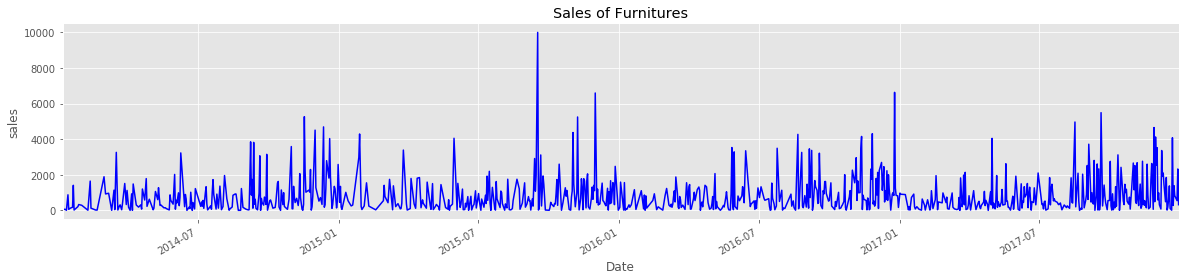

In [44]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [45]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

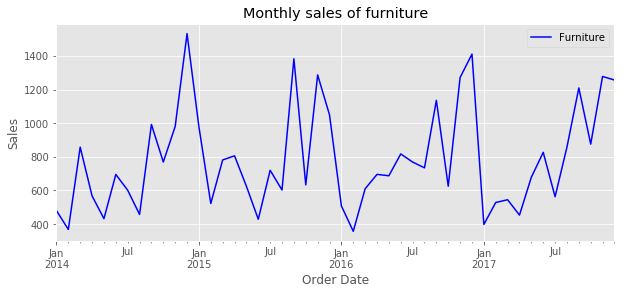

In [46]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [47]:
X = df.values

In [48]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


In [49]:
# create a differenced series to make it stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [50]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [51]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [52]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [53]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [54]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [65]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [56]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
35/35 [==============================] - 1s 29ms/step - loss: 0.2426
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2383
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2346
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2311
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2278
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2245
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2215
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2186
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2158
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2130
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2099
Epoch 2/5
35/35 [====

35/35 [==============================] - 0s 3ms/step - loss: 0.1627
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1624
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1623
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1567
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1621
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1619
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1616
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1612
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1611
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1541
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1541
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1540
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1501
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1539
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1538
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1538
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1537
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1499
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1536
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1536
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1535
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1450
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1450
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1449
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1379
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1448
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1445
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1443
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1375
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1442
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1438
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1438
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

35/35 [==============================] - 0s 2ms/step - loss: 0.1356
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1355
Epoch 5/5
35/35 [==============================] - 0s 6ms/step - loss: 0.1359
Epoch 1/5
35/35 [==============================] - 0s 5ms/step - loss: 0.1361
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1403
Epoch 3/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1352
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1354
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1357
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1358
Epoch 2/5
35/35 [==============================] - 0s 7ms/step - loss: 0.1404
Epoch 3/5
35/35 [==============================] - 0s 4ms/step - loss: 0.1351
Epoch 4/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1355
Epoch 5/5
35/35 [==============================] - 0s 2ms/step - loss: 0.1

array([[-0.08823664],
       [ 0.03483594],
       [-0.43769616],
       [-0.11927412],
       [ 0.03299551],
       [-0.17257705],
       [ 0.00480311],
       [ 0.19218034],
       [-0.3536134 ],
       [ 0.00329714],
       [-0.1597254 ],
       [-0.63785475],
       [-0.21742657],
       [ 0.01417107],
       [-0.08890972],
       [-0.0486846 ],
       [ 0.12946415],
       [ 0.2881238 ],
       [ 0.0096472 ],
       [ 0.2415449 ],
       [-0.5900101 ],
       [ 0.18177149],
       [-0.5367815 ],
       [-0.24389514],
       [ 0.15722197],
       [ 0.2616787 ],
       [ 0.03840306],
       [ 0.05131117],
       [ 0.15139994],
       [ 0.06609308],
       [ 0.23463655],
       [ 0.32030368],
       [-0.17399243],
       [ 0.6385969 ],
       [-0.38606924]], dtype=float32)

In [57]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [58]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [60]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=1028.238588, Expected=1410.719808
Month=2, Predicted=465.829797, Expected=397.602133
Month=3, Predicted=540.609508, Expected=528.179800
Month=4, Predicted=595.590437, Expected=544.672240
Month=5, Predicted=607.589957, Expected=453.297905
Month=6, Predicted=686.193863, Expected=678.302328
Month=7, Predicted=795.765393, Expected=826.460291
Month=8, Predicted=831.590769, Expected=562.524857
Month=9, Predicted=842.361678, Expected=857.881889
Month=10, Predicted=971.657222, Expected=1209.508583
Month=11, Predicted=1026.483215, Expected=875.362728
Month=12, Predicted=1084.781702, Expected=1277.817759


In [61]:
len(predictions)

12

Test RMSE: 248.039


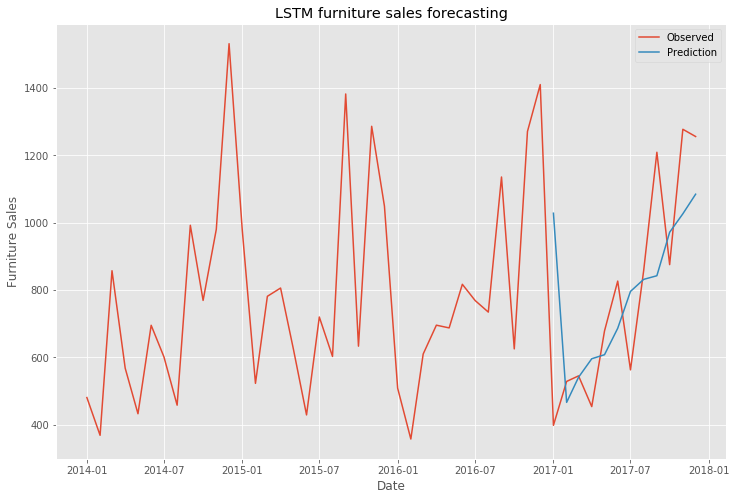

In [62]:
# report performance
rcParams['figure.figsize'] = 12, 8
from math import sqrt
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions,label="Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [63]:
predictions

[1028.2385877641213,
 465.82979672974034,
 540.6095080247945,
 595.5904369945129,
 607.5899569126898,
 686.1938629734807,
 795.7653930546197,
 831.5907693706495,
 842.3616776133199,
 971.6572224454357,
 1026.4832147875536,
 1084.7817024111987]

In [64]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))
performance(raw_values[-12:], predictions)

 The MSE of forecasts is 61523.12
 The RMSE of forecasts is 248.04
 The MAPE of forecasts is 29.1


Source: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/